### 1. Prepare

In [1]:
!pip install tensorflow

INFO: pip is looking at multiple versions of pyts to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 136.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.4 MB/s eta 0

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

import wandb
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
# from orion.primitives.tadgan import TadGAN
# from orion.primitives.aer import AER
# from orion import Orion
import torch
import torch.nn as nn
import torch.optim as optim
import time

import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from itertools import product

### 2. Load data

In [ ]:
#5ca775ac3430d5c91b43f624ebea0ca3cdd83b73

In [4]:
path = '/content/drive/MyDrive/bistelligence'

data_path = os.path.join(path, "BIS_data/BISTelligen_Project_Data.csv")
image_path = os.path.join(path, "BISTelligence/src/image")
data=pd.read_csv(data_path)

In [ ]:
data.head()

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
0,1,1030.888889,1758.333333,1993.888889,438.298608,1.866068,1745.631110,0.890293
1,1,1019.508475,1742.881356,2095.932203,445.253134,1.870993,1615.059148,0.913187
2,1,1025.300000,1737.666667,2083.500000,452.722338,1.869140,1714.612494,0.888425
3,1,1019.383333,1751.666667,2089.833333,453.906117,1.853422,1689.548169,0.887922
4,1,1017.316667,1772.500000,2103.166667,447.134201,1.858652,1615.978827,0.881195


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              1764 non-null   int64  
 1   Pressure         1764 non-null   float64
 2   Power1           1764 non-null   float64
 3   Power2           1764 non-null   float64
 4   Vibration_Peak1  1764 non-null   float64
 5   Vibration_RMS1   1764 non-null   float64
 6   Vibration_Peak2  1764 non-null   float64
 7   Vibration_RMS2   1764 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 110.4 KB


### 3. Preprocessing

*   업체 측에서 임의로 부여한 미션 해결



In [ ]:
data[data['Vibration_RMS2'] < 0]

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
982,4,1027.24236,1761.611228,2055.250646,460.673714,1.860608,1771.662869,-0.000035


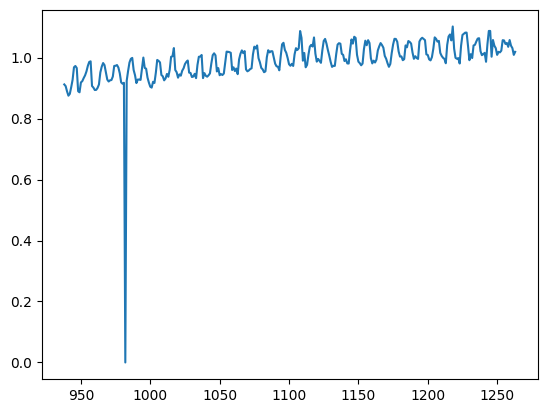

In [ ]:
plt.plot(data[data['key']==4]['Vibration_RMS2'])

In [5]:
# noise data 발생 지점 기준으로 이전 40개 인덱스, 이후 40개 인덱스에 대한 Vibration_RMS2 평균값으로 대체
# noise data index=982, index 942~981(40개), index 983~1022(40개)
prev_sum=data[data['key']==4].loc[942:981]['Vibration_RMS2'].sum()
after_sum=data[data['key']==4].loc[983:1022]['Vibration_RMS2'].sum()
aver=(prev_sum+after_sum)/80
data.loc[data['Vibration_RMS2']<0,'Vibration_RMS2']=aver

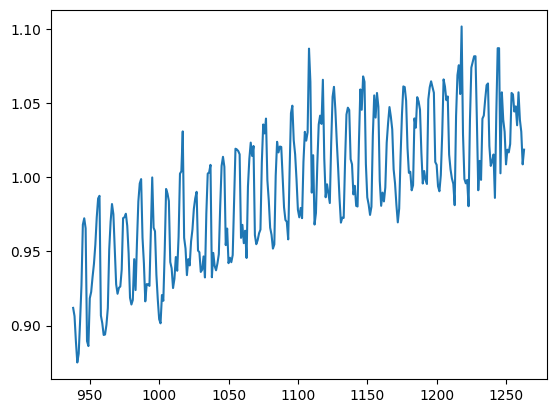

In [ ]:
plt.plot(data[data['key']==4]['Vibration_RMS2'])

### 4. EDA with wandb

*   이상을 탐지하는 태스크로 각 key는 기존에 관리자가 이상이라고 임의로 판단하고 중단한 이후 다시 동작 시에 1씩 증가하는 형태임을 확인하였다.
*   각 key가 중단된 시점의 value를 분석하여 어떤 feature가 영향이 컸는지 파악한다.

In [ ]:
# wandb 초기화
wandb.init(project="BISTelligen_Project_Analysis", name="Data_Analysis_Run")
# 기본 정보 로깅
wandb.log({"data_shape": data.shape})
wandb.log({"columns": data.columns.tolist()})

# 기술 통계량 계산 및 로깅
stats = data.describe()
wandb.log({"descriptive_stats": wandb.Table(dataframe=stats)})

# 결측치 정보 로깅
missing_data = data.isnull().sum()
wandb.log({"missing_data": wandb.Table(dataframe=missing_data.to_frame('missing_count'))})

# 상관관계 분석 (수치형 컬럼에 대해서만)
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = data[numeric_cols].corr()

# 상관관계 히트맵 생성 및 로깅
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
wandb.log({"correlation_heatmap": wandb.Image(plt)})
plt.close()

# 각 수치형 컬럼에 대한 히스토그램 생성 및 로깅
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    wandb.log({f"{col}_distribution": wandb.Image(plt)})
    plt.close()

# 데이터 샘플 로깅
wandb.log({"data_sample": wandb.Table(dataframe=data.head())})

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# scaling 전
data.describe()

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,3.349206,1029.587995,1796.089208,2164.182666,473.236279,1.859088,1769.655457,0.998760
std,1.680843,30.857242,56.299360,174.158013,14.674220,0.043308,88.254406,0.058174
min,1.000000,1003.600000,1716.111111,1904.412839,432.384464,1.757011,1543.133416,0.846306
25%,2.000000,1018.328190,1768.336433,2039.913975,462.758782,1.838049,1711.935295,0.962336
50%,3.000000,1021.389993,1785.236494,2092.104392,472.306302,1.857705,1764.891307,0.994855
75%,5.000000,1026.641906,1804.262637,2284.389567,482.998497,1.871132,1815.156379,1.038209
max,6.000000,1261.577503,2227.901131,3244.341245,519.914237,2.216824,2283.829118,1.352378


In [ ]:
scaler=MinMaxScaler()
scaled_data=pd.DataFrame(scaler.fit_transform(data.drop(['key'],axis=1)),columns=data.columns[1:])
# scaling 후
scaled_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,0.100737,0.156271,0.193868,0.466719,0.221996,0.305823,0.301250
std,0.119612,0.110005,0.129976,0.167648,0.094186,0.119151,0.114952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.057091,0.102044,0.101126,0.347017,0.176241,0.227896,0.229275
50%,0.068959,0.135066,0.140076,0.456094,0.218988,0.299391,0.293532
75%,0.089318,0.172242,0.283580,0.578249,0.248190,0.367253,0.379201
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# key 값을 다시 추가
scaled_data['key'] = data['key']

# 키별로 데이터 그룹화
grouped_data = scaled_data.groupby('key')

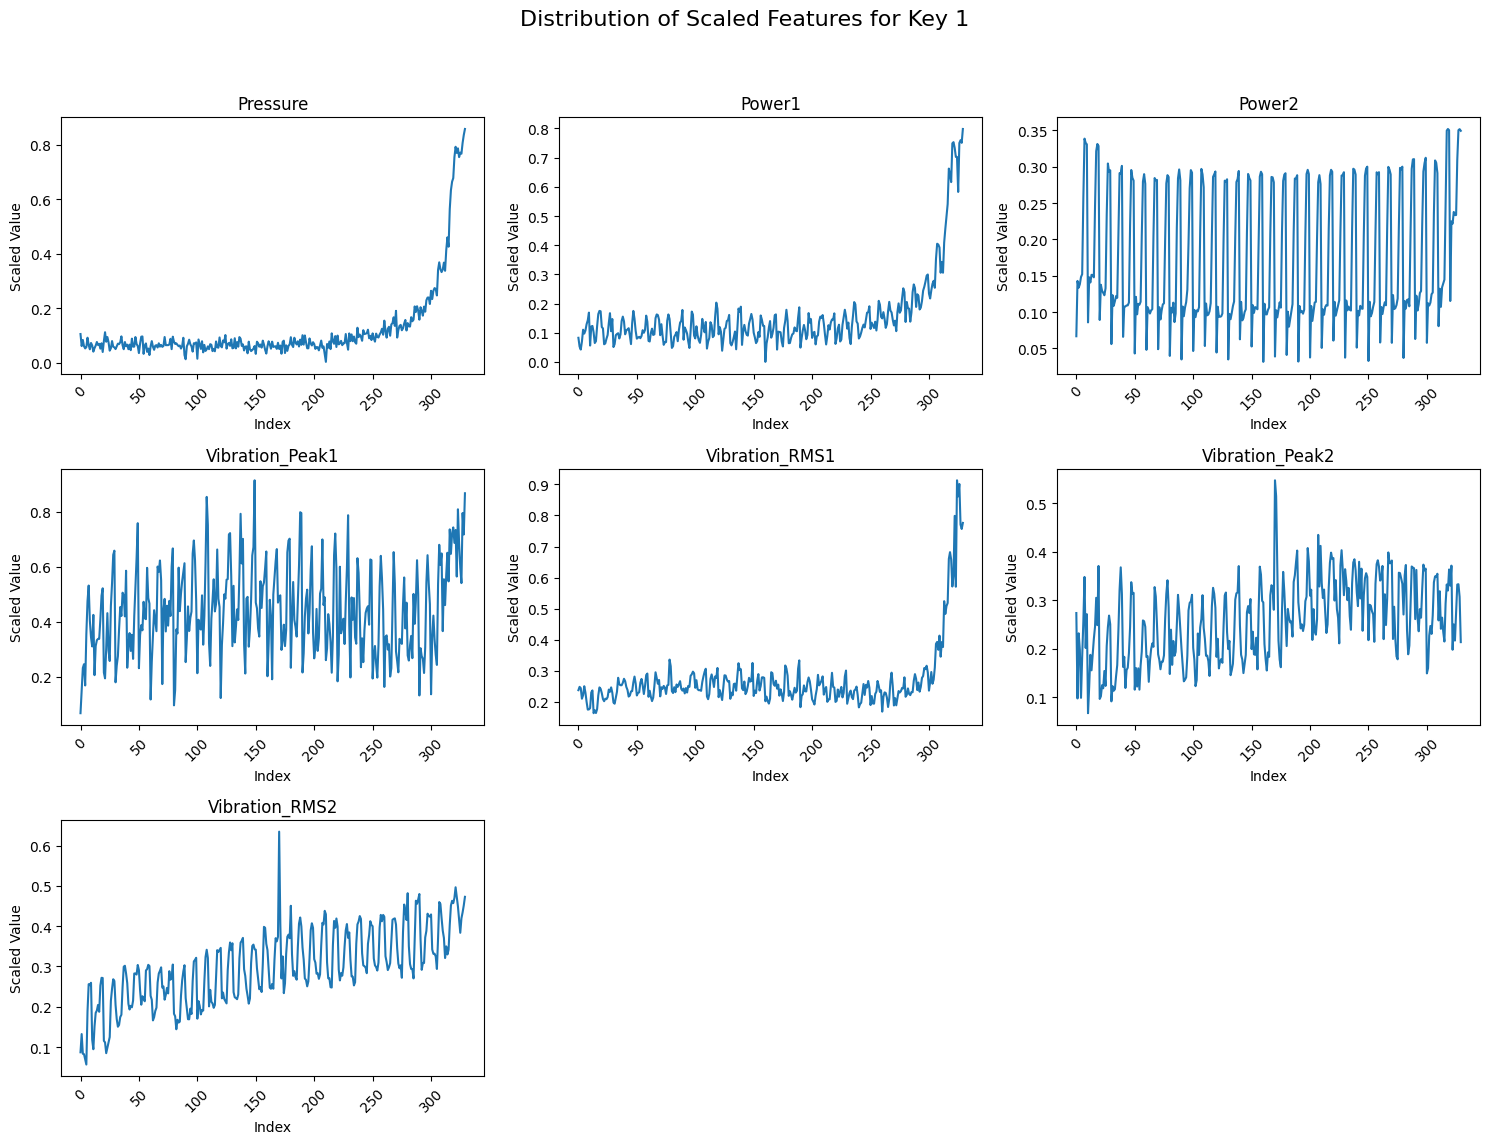

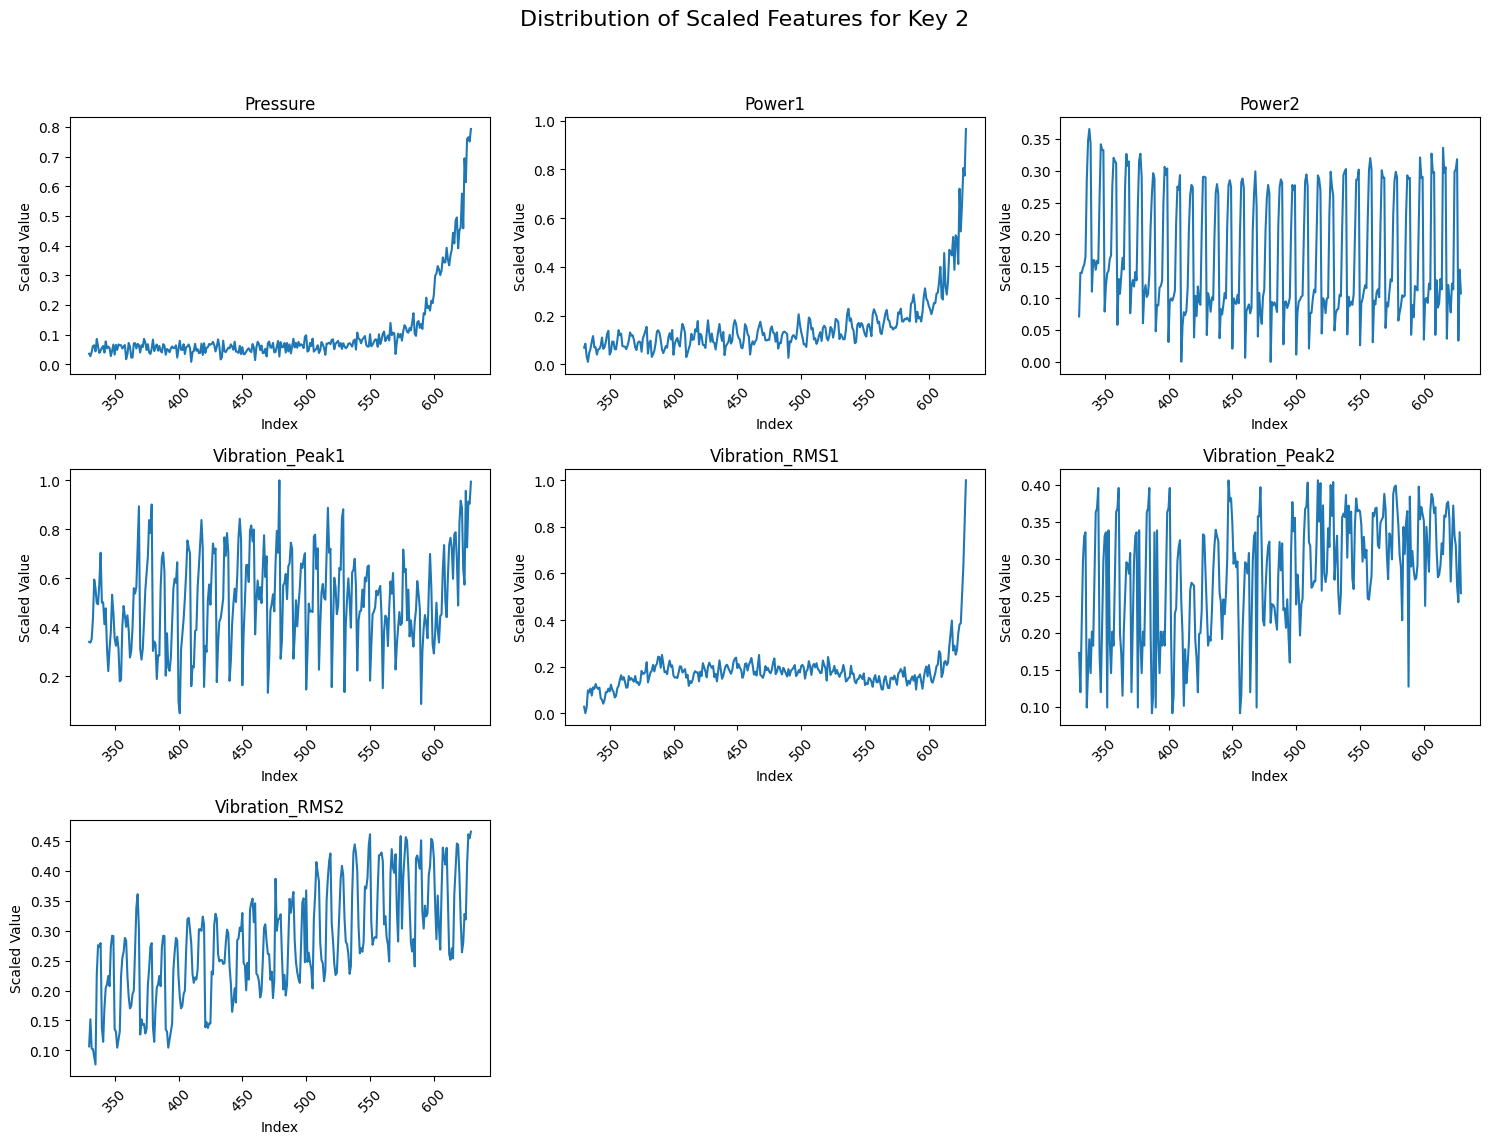

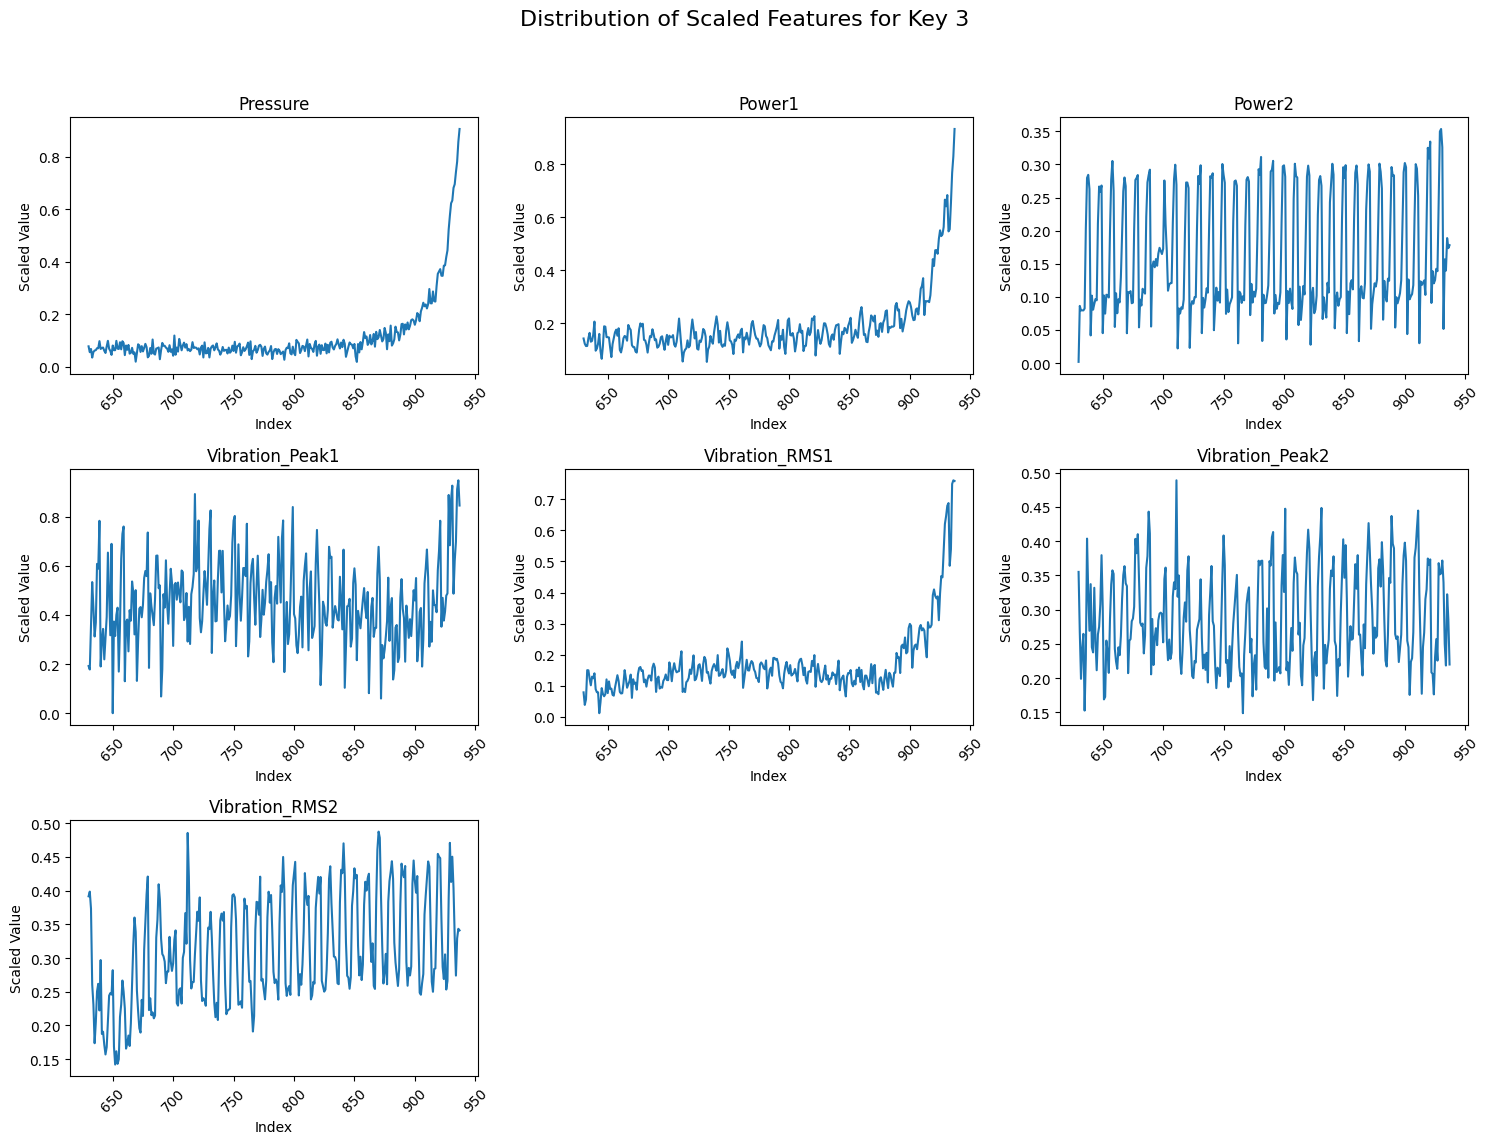

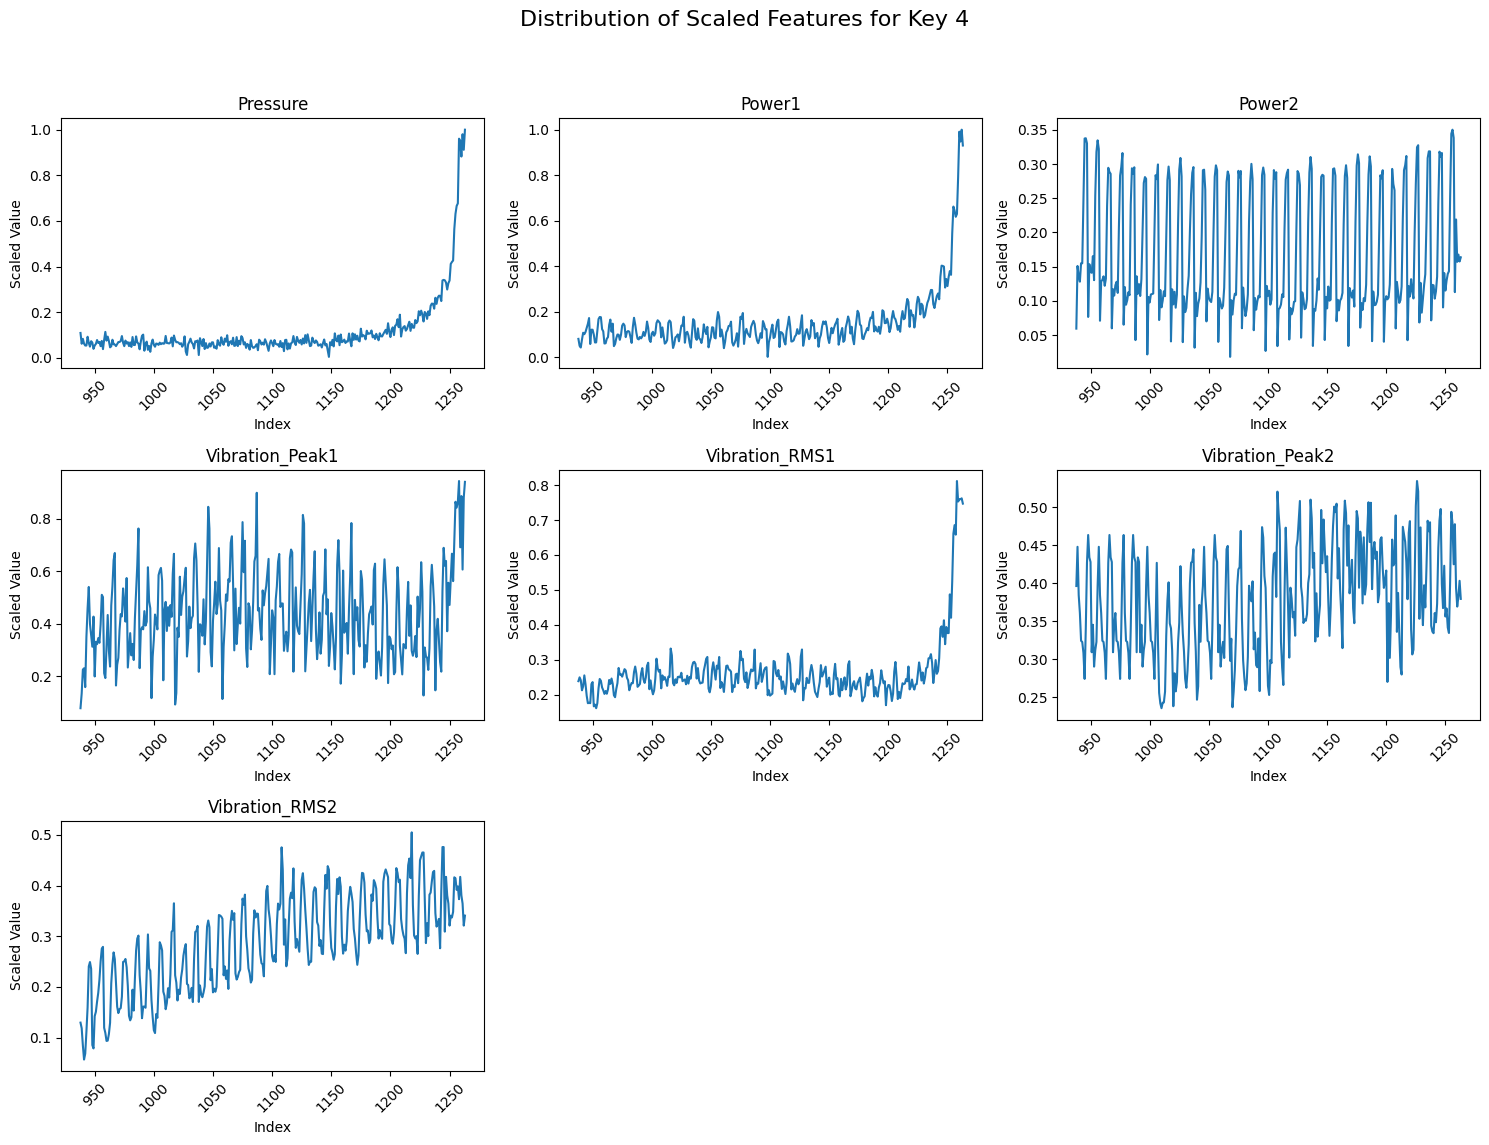

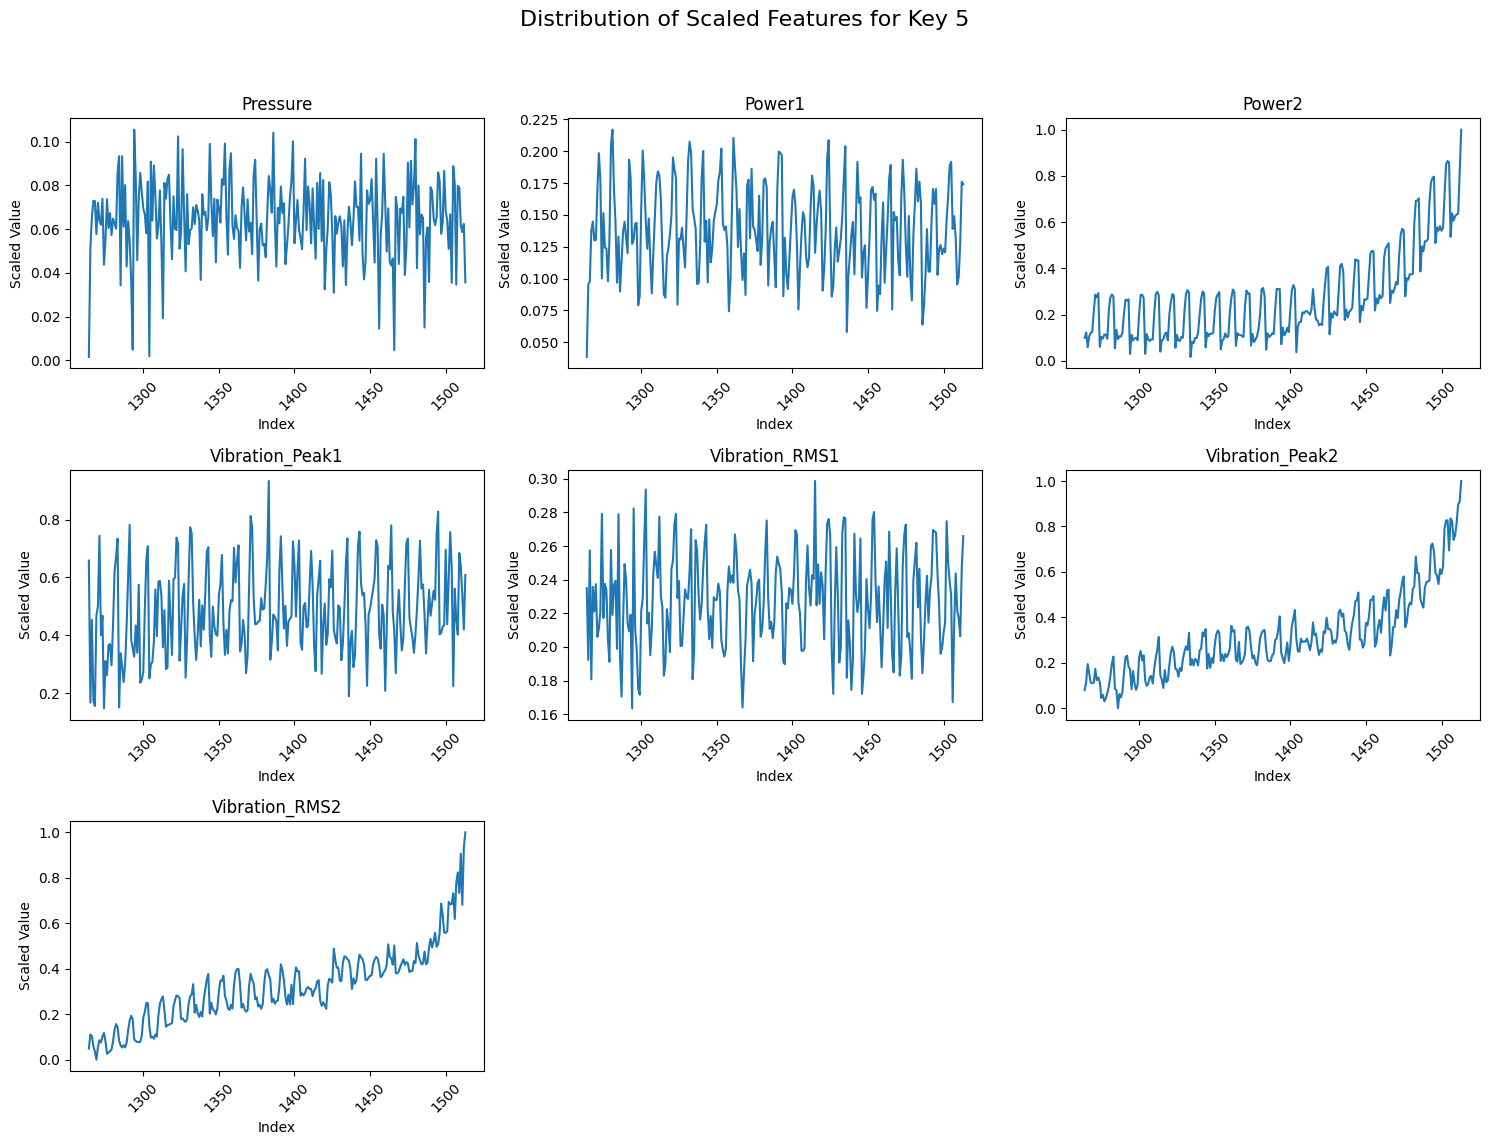

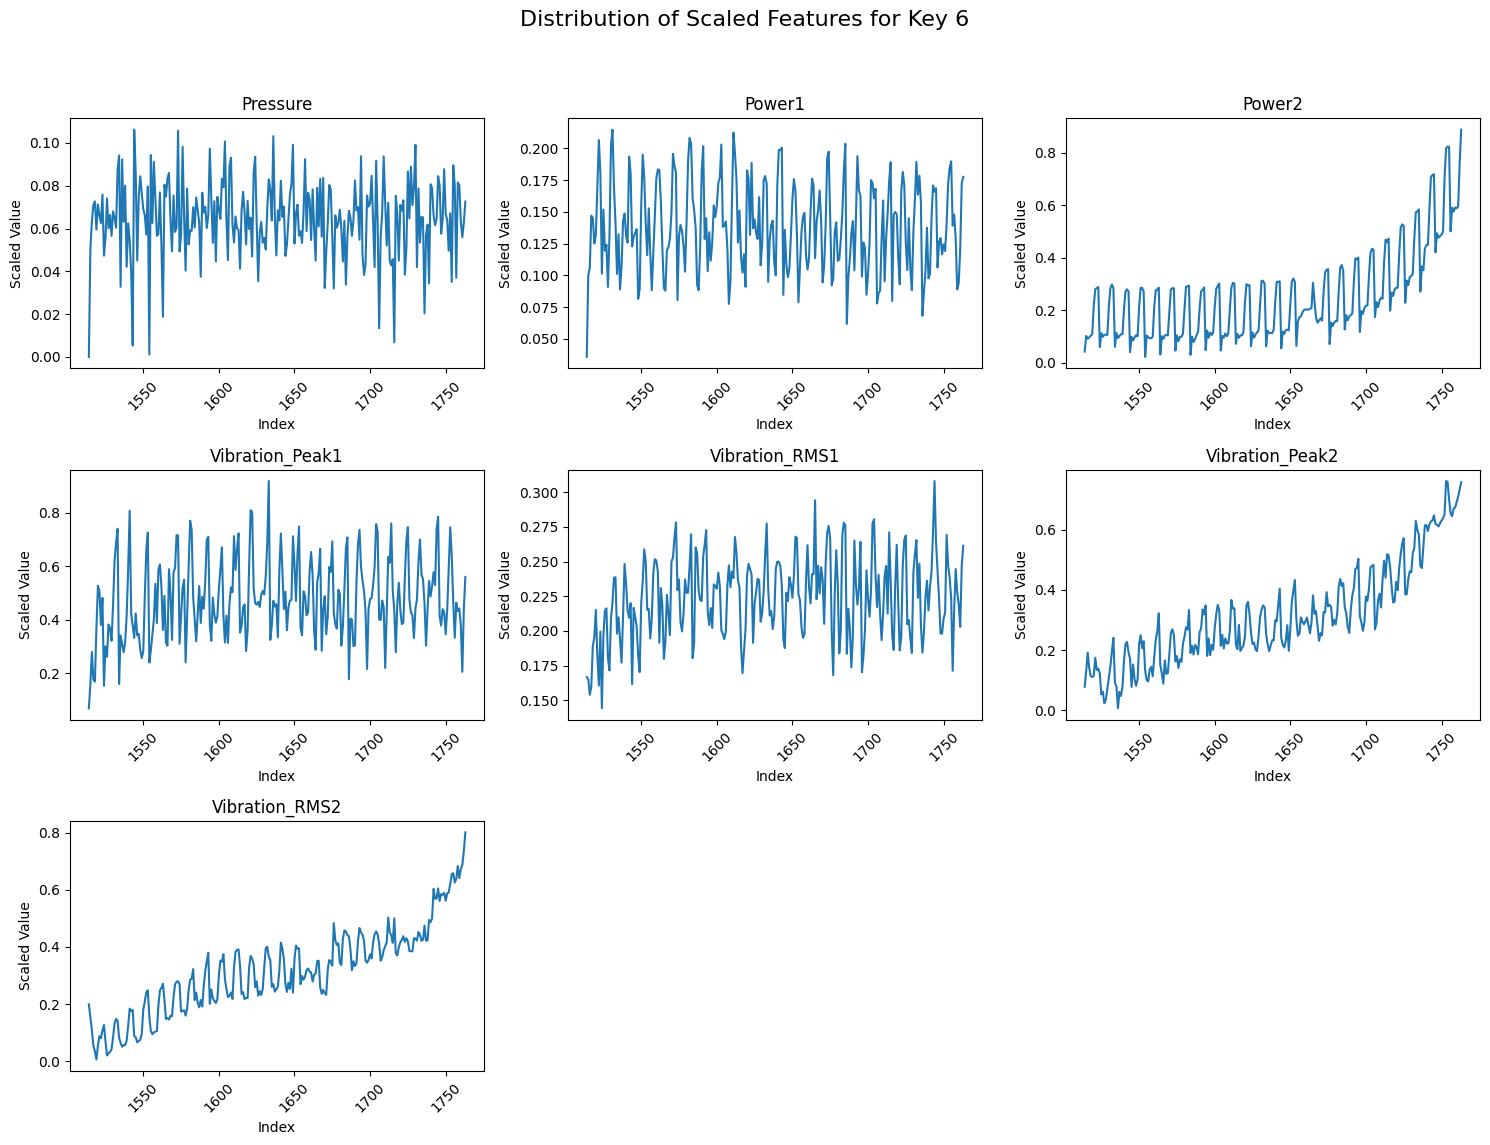

In [ ]:
# 컬럼 리스트 (key 제외)
columns = [col for col in scaled_data.columns if col != 'key']

# 전체 플롯 설정
n_keys = len(grouped_data)
n_cols = len(columns)

# 각 키별로 개별 차트 생성 및 로깅
for key, group in grouped_data:
    fig, axes = plt.subplots(math.ceil(n_cols/3), 3, figsize=(15, 4*math.ceil(n_cols/3)))
    fig.suptitle(f'Distribution of Scaled Features for Key {key}', fontsize=16)

    for i, column in enumerate(columns):
        ax = axes[i//3, i%3]
        ax.plot(group.index, group[column])
        ax.set_title(column)
        ax.set_xlabel('Index')
        ax.set_ylabel('Scaled Value')
        ax.tick_params(axis='x', rotation=45)

    # 사용하지 않는 서브플롯 제거
    for i in range(n_cols, 3*math.ceil(n_cols/3)):
        fig.delaxes(axes[i//3, i%3])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # wandb에 각 키별 차트 로깅
    wandb.log({f"scaled_features_distribution_key_{key}": wandb.Image(plt)})
    # plt.close()

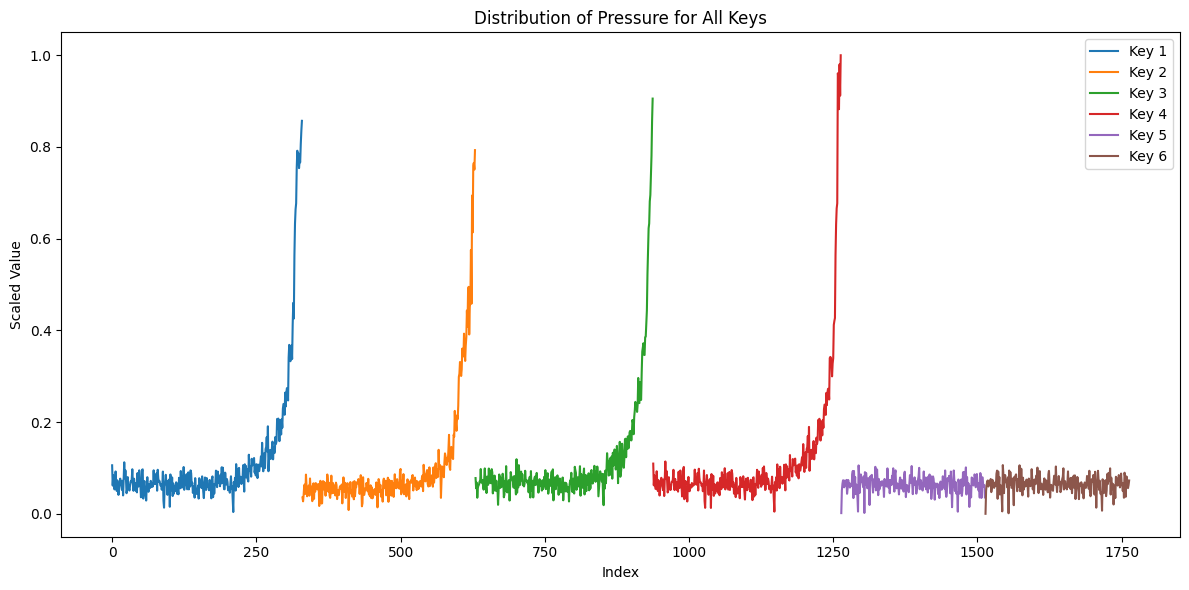

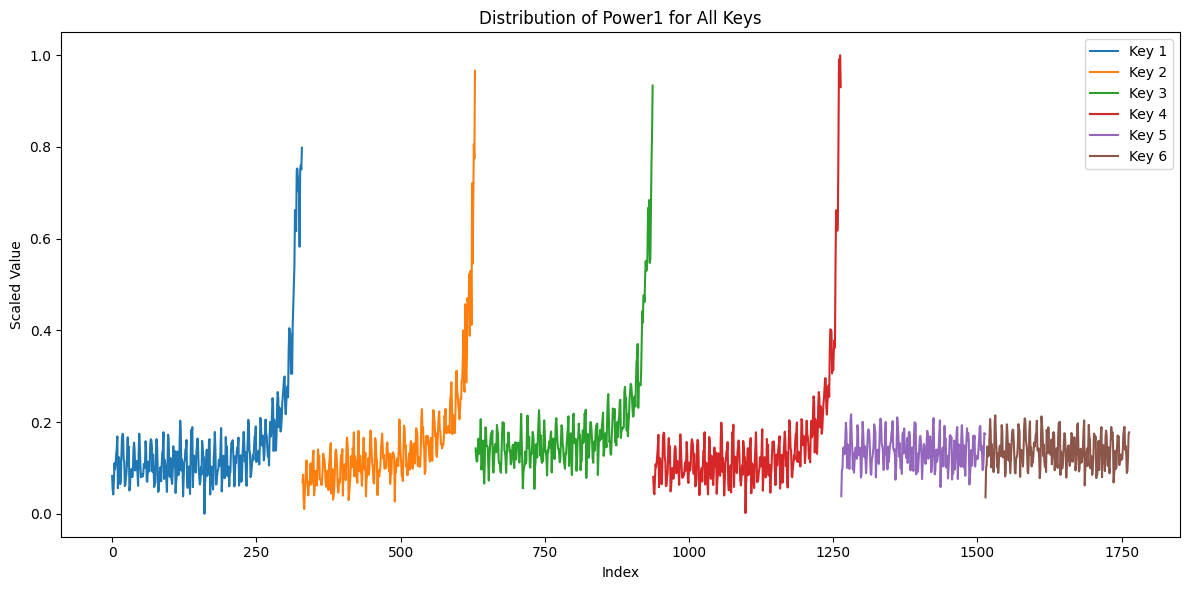

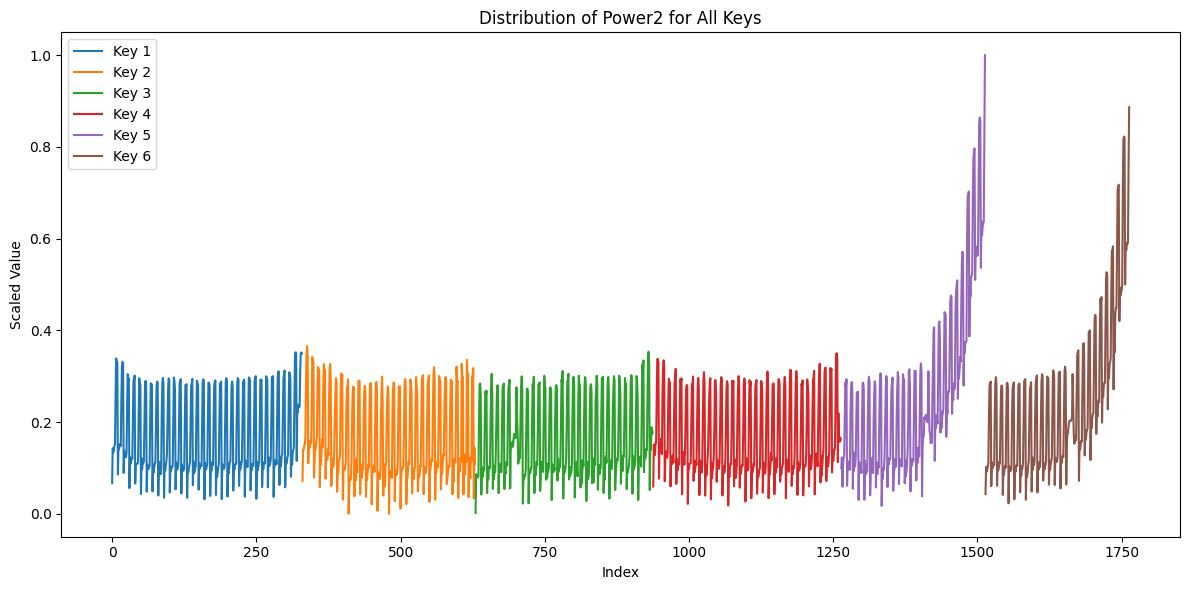

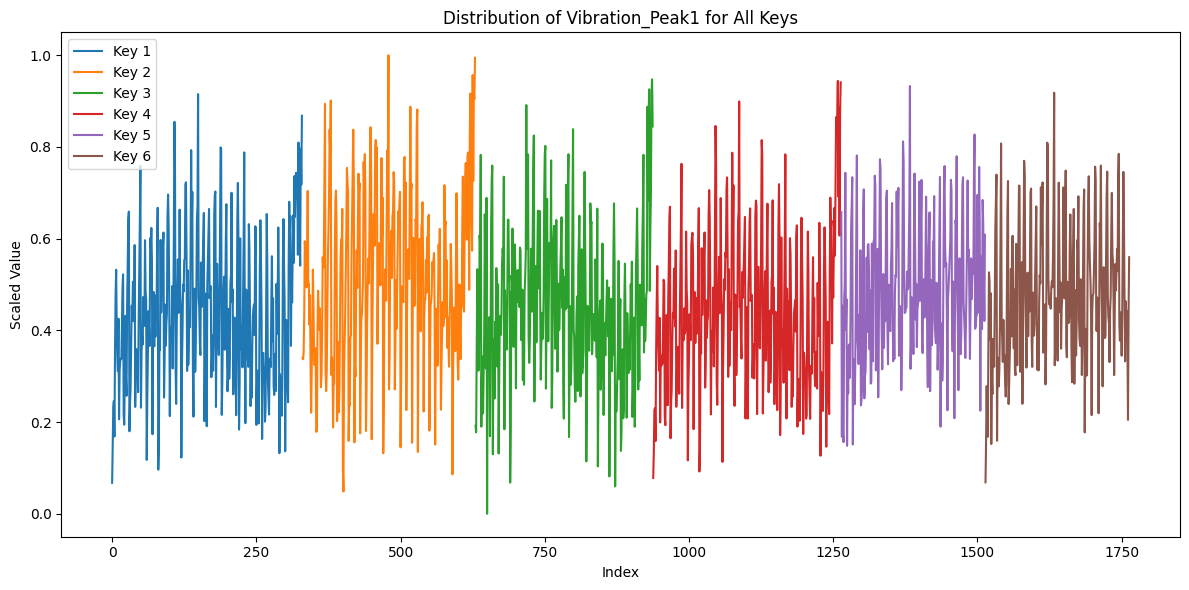

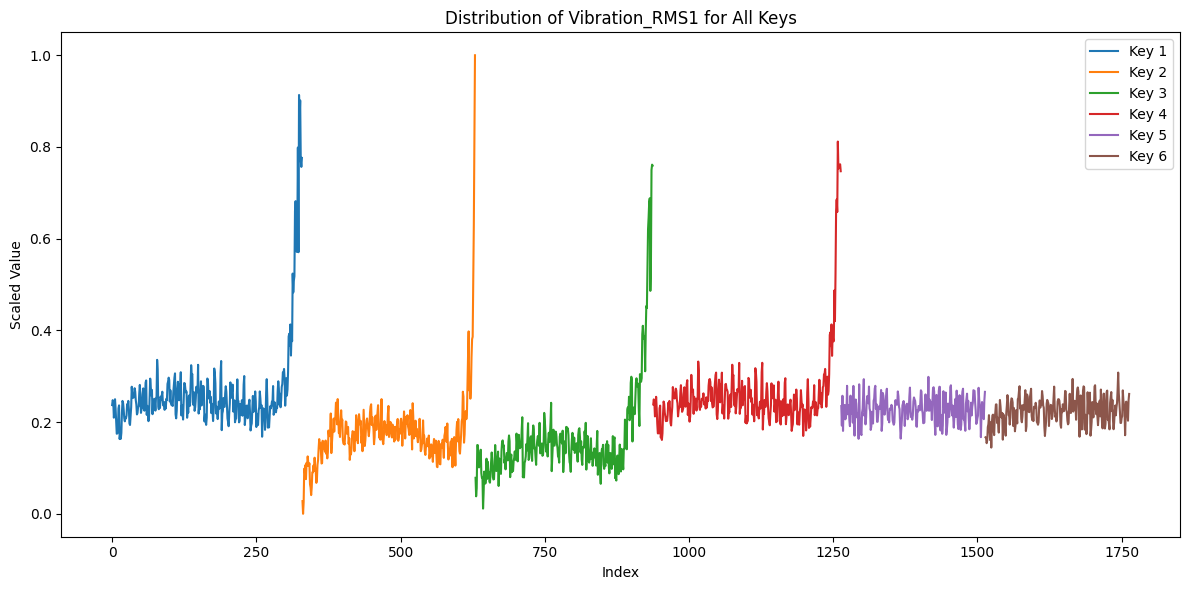

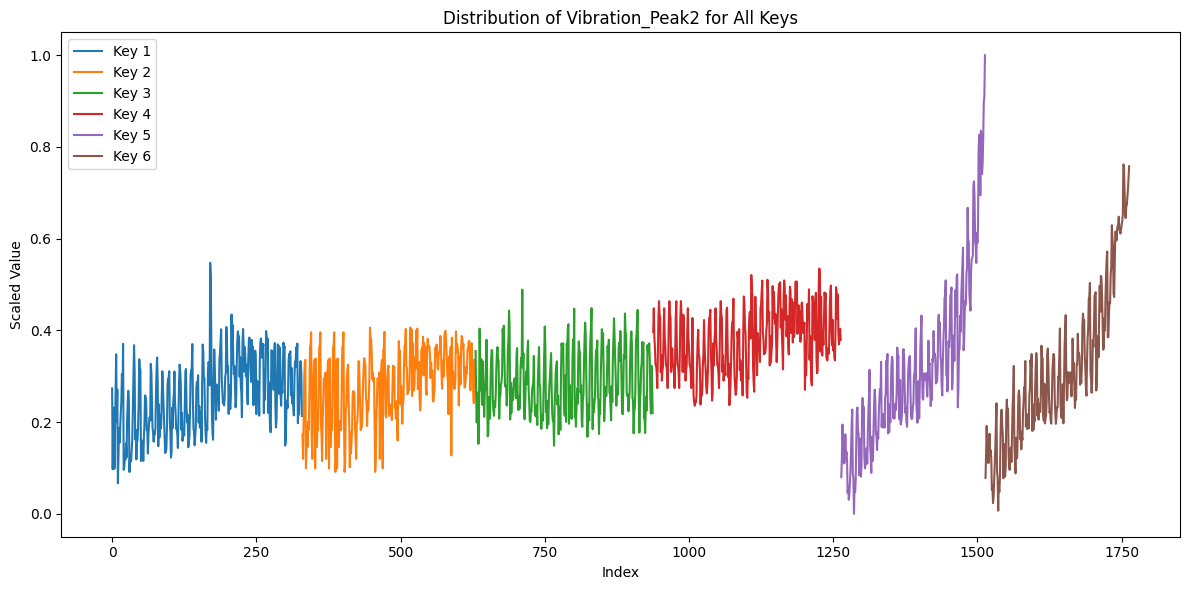

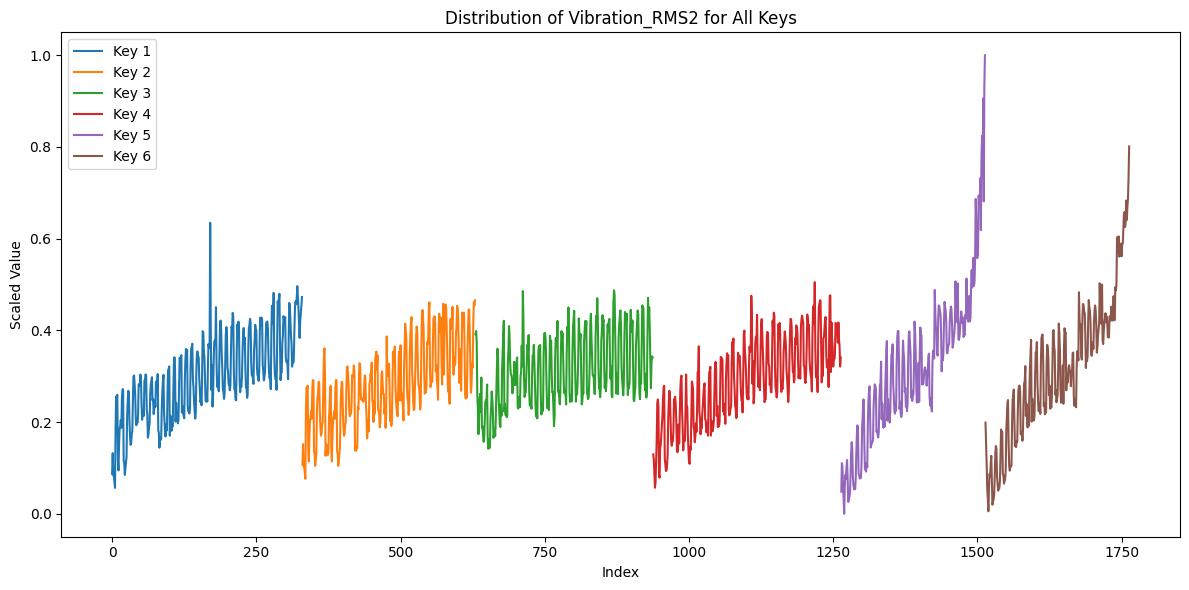

In [ ]:
# 각 컬럼별로 개별 차트 생성 및 로깅
for column in columns:
    plt.figure(figsize=(12, 6))

    for key in scaled_data['key'].unique():
        key_data = scaled_data[scaled_data['key'] == key]
        plt.plot(key_data.index, key_data[column], label=f'Key {key}')

    plt.title(f'Distribution of {column} for All Keys')
    plt.xlabel('Index')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.tight_layout()

    # wandb에 각 컬럼별 차트 로깅
    wandb.log({f"feature_distribution_{column}": wandb.Image(plt)})
    # plt.close()

### 5. Modeling

*   기존에 진행했던 모델 (Local Outlier Factor : 2023.02)
    - 성능 79%(21% 조기탐지 but, 50% 지점에서 이상으로 탐지하는 등 오차가 큰 편이며 신뢰성 부족)
*   현재 보완점을 찾기 위해 선택한 모델 (VQVAE : 2024.11)
    - 성능 93%(7% 조기탐지)



In [6]:
scaler=MinMaxScaler()
scaled_data=pd.DataFrame(scaler.fit_transform(data.drop(['key'],axis=1)),columns=data.columns[1:])
# scaling 후
scaled_data.describe()
# key 값을 다시 추가
scaled_data['key'] = data['key']

In [7]:
m_df = scaled_data.copy()

In [8]:
m_df.head()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2,key
0,0.105780,0.082499,0.066777,0.067567,0.237177,0.273389,0.086917,1
1,0.061666,0.052307,0.142933,0.147020,0.247887,0.097106,0.132156,1
2,0.084116,0.042118,0.133654,0.232354,0.243858,0.231511,0.083227,1
3,0.061181,0.069473,0.138381,0.245878,0.209673,0.197672,0.082232,1
4,0.053170,0.110180,0.148332,0.168511,0.221047,0.098347,0.068940,1


In [9]:
exclude_columns = ['key']
data_columns = m_df.drop(columns=exclude_columns)
data_without_key = pd.DataFrame(m_df, columns=data_columns.columns)

In [10]:
# 파라미터 그리드 정의
param_grid = {
    'n_neighbors': [5, 10, 20, 50],
    'contamination': [0.01, 0.05, 0.1, 0.2],
    'metric': ['euclidean', 'manhattan']
}

# 그리드 서치 함수 정의
def grid_search_lof(X, param_grid):
    best_score = -1
    best_params = None
    results = []

    # 모든 파라미터 조합에 대해 반복
    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))

        # LOF 모델 생성 및 학습
        lof = LocalOutlierFactor(**current_params)
        y_pred = lof.fit_predict(X)

        # 실루엣 점수 계산 (이상치를 -1, 정상을 1로 레이블링)
        if len(np.unique(y_pred)) > 1:  # 두 개 이상의 클래스가 있는 경우에만 계산
            score = silhouette_score(X, y_pred)
        else:
            score = -1  # 모든 샘플이 같은 클래스로 예측된 경우

        results.append({**current_params, 'score': score})

        # 최고 점수 업데이트
        if score > best_score:
            best_score = score
            best_params = current_params

    return best_params, best_score, results

# 그리드 서치 실행
best_params, best_score, all_results = grid_search_lof(m_df, param_grid)

# 결과 출력
print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

# 모든 결과를 데이터프레임으로 변환하여 출력
results_df = pd.DataFrame(all_results)
print(results_df.sort_values('score', ascending=False))

# 최적의 파라미터로 LOF 모델 생성 및 이상치 탐지
best_lof = LocalOutlierFactor(**best_params)
y_pred = best_lof.fit_predict(m_df)

# 이상치 비율 계산
anomaly_ratio = (y_pred == -1).sum() / len(y_pred)
print(f"Anomaly ratio with best parameters: {anomaly_ratio:.2%}")

Best Parameters: {'n_neighbors': 50, 'contamination': 0.01, 'metric': 'manhattan'}
Best Silhouette Score: 0.15701660196375813
    n_neighbors  contamination     metric     score
25           50           0.01  manhattan  0.157017
24           50           0.01  euclidean  0.144924
0             5           0.01  euclidean  0.092131
16           20           0.01  euclidean  0.064661
26           50           0.05  euclidean  0.046254
8            10           0.01  euclidean  0.038726
27           50           0.05  manhattan  0.036378
9            10           0.01  manhattan  0.025017
28           50           0.10  euclidean  0.024249
30           50           0.20  euclidean  0.021697
29           50           0.10  manhattan  0.019742
31           50           0.20  manhattan  0.016198
2             5           0.05  euclidean  0.015347
23           20           0.20  manhattan  0.014729
11           10           0.05  manhattan  0.013163
22           20           0.20  euclidean 

Key change at 0 to 329: Anomaly detected 51.67% early at index 170
Key change at 330 to 629: Anomaly detected 95.32% early at index 615
Key change at 630 to 937: Anomaly detected 95.77% early at index 924
Key change at 938 to 1263: Anomaly detected 52.31% early at index 1108
Key change at 1264 to 1513: Anomaly detected 99.60% early at index 1512
Prediction Result: 78.93%


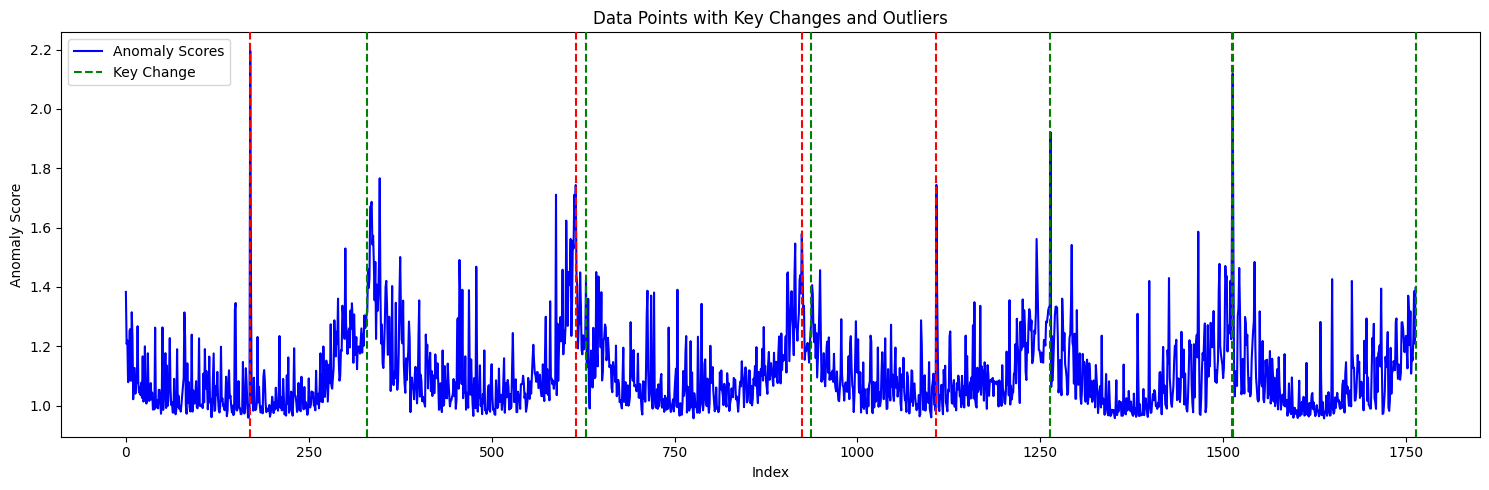

In [31]:
# Detect key change points and store indices of changes
key_change_indices = m_df.index[m_df['key'].diff() != 0].tolist()

# Adjust to capture the previous index (the one before the change)
key_change_indices = [m_df.index[i - 1] for i in range(1, len(m_df.index)) if m_df['key'].iloc[i] != m_df['key'].iloc[i - 1]]

# Remove index 0 if it's in the list
key_change_indices = [idx for idx in key_change_indices if idx != 0]

# Add the last index to key_change_indices
key_change_indices.append(m_df.index[-1])

# LOF 모델 생성 및 학습
n_neighbors = 50
contamination = 0.01
metrics = 'manhattan'
# Fit the model
model_lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metrics)
model_lof.fit(data_without_key)

# Get the anomaly scores (negative outlier factor)
anomaly_scores = model_lof.negative_outlier_factor_

# The anomaly scores are negative, so we can convert them to positive values to indicate anomaly
# The more negative the score, the more anomalous the data
anomaly_scores = -anomaly_scores  # Invert to make the score positive (more positive = more anomalous)

# Visualize Data Points and Outliers
plt.figure(figsize=(15, 5))

# Plot the anomaly scores in blue
plt.plot(m_df.index, anomaly_scores, color='blue', label='Anomaly Scores')

# Mark key change points with green vertical lines
for i, idx in enumerate(key_change_indices):
    plt.axvline(x=idx, color='green', linestyle='--', label='Key Change' if i == 0 else None, zorder=10)

# Use fit_predict to get predictions on training data
y_pred = model_lof.fit_predict(data_without_key)

key_change_indices.insert(0, 0)
prediction_lines = []

# Iterate through the key change indices and find the last red outlier for each segment
for i in range(1, len(key_change_indices)):
    start_idx = key_change_indices[i - 1] if i == 1 else key_change_indices[i - 1] + 1
    end_idx = key_change_indices[i]

    # Identify outliers in this segment
    segment_outliers = m_df.index[start_idx:end_idx][y_pred[start_idx:end_idx] == -1]

    if len(segment_outliers) > 0:
        # Get the last outlier index in the segment
        last_outlier_idx = segment_outliers[-1]

        # Mark the last outlier with a red vertical line
        plt.axvline(x=last_outlier_idx, color='red', linestyle='--', label='Anomaly (95%)' if i == 0 else None, zorder=5)

        # Calculate the percentage of early anomaly detection
        anomaly_detection_percentage = ((last_outlier_idx - start_idx) / (end_idx - start_idx)) * 100
        prediction_lines.append(anomaly_detection_percentage)

        print_text = f"Key change at {start_idx} to {end_idx}: Anomaly detected {anomaly_detection_percentage:.2f}% early at index {last_outlier_idx}"
        print(print_text)
        # wandb.log({"Log": print_text})

print('======================================================')
prediction_mean = np.mean(prediction_lines)
print(f"Prediction Result: {prediction_mean:.2f}%")

# Add labels and legend
plt.title('Data Points with Key Changes and Outliers')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig(f"{image_path}/anomaly_detection_plot_LocalOutlierFactor_241110.png")
# wandb.log({"Anomaly Detection Plot": wandb.Image(f"{image_path}/anomaly_detection_plot_LocalOutlierFactor_241110.png")})

# Show the plot
plt.show()


In [22]:
# Define the VQVAE model
class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_embeddings):
        super(VQVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

        self.quantizer = nn.Embedding(num_embeddings, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def encode(self, x):
        z_e = self.encoder(x)
        z_q = self.quantizer(torch.argmax(z_e, dim=-1))  # Vector Quantization
        return z_q, z_e

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z_q, z_e = self.encode(x)
        recon_x = self.decode(z_q)
        return recon_x, z_e

In [23]:
# Convert to a PyTorch tensor and reshape for VQVAE
window_size = 20  # Example window size
X_train = np.array([data_without_key[i:i + window_size] for i in range(len(data_without_key) - window_size)])
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# Step 2: Train the VQVAE Model
latent_dim = 20
num_embeddings = 64  # Number of embeddings in quantizer (adjust as needed)
model = VQVAE(input_dim=X_train.shape[2], latent_dim=latent_dim, num_embeddings=num_embeddings)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    recon_x, z_e = model(X_train_tensor)
    loss = criterion(recon_x, X_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')


Epoch [0/100], Loss: 0.1268
Epoch [10/100], Loss: 0.0220
Epoch [20/100], Loss: 0.0180
Epoch [30/100], Loss: 0.0161
Epoch [40/100], Loss: 0.0155
Epoch [50/100], Loss: 0.0151
Epoch [60/100], Loss: 0.0150
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0150
Epoch [90/100], Loss: 0.0150


Orange line at index 314 is at 95.44% of the range from 0 to 329.
Orange line at index 617 is at 95.99% of the range from 330 to 629.
Orange line at index 921 is at 94.79% of the range from 630 to 937.
Orange line at index 1254 is at 97.23% of the range from 938 to 1263.
Orange line at index 1483 is at 87.95% of the range from 1264 to 1513.
Orange line at index 1733 is at 87.95% of the range from 1514 to 1763.
Red line at index 317 is at 96.35% of the range from 0 to 329.
Red line at index 624 is at 98.33% of the range from 330 to 629.
Red line at index 929 is at 97.39% of the range from 630 to 937.
Red line at index 1255 is at 97.54% of the range from 938 to 1263.
Red line at index 1494 is at 92.37% of the range from 1264 to 1513.
Red line at index 1753 is at 95.98% of the range from 1514 to 1763.
Prediction Result(95%): 93.23%
Prediction Result(97%): 96.33%


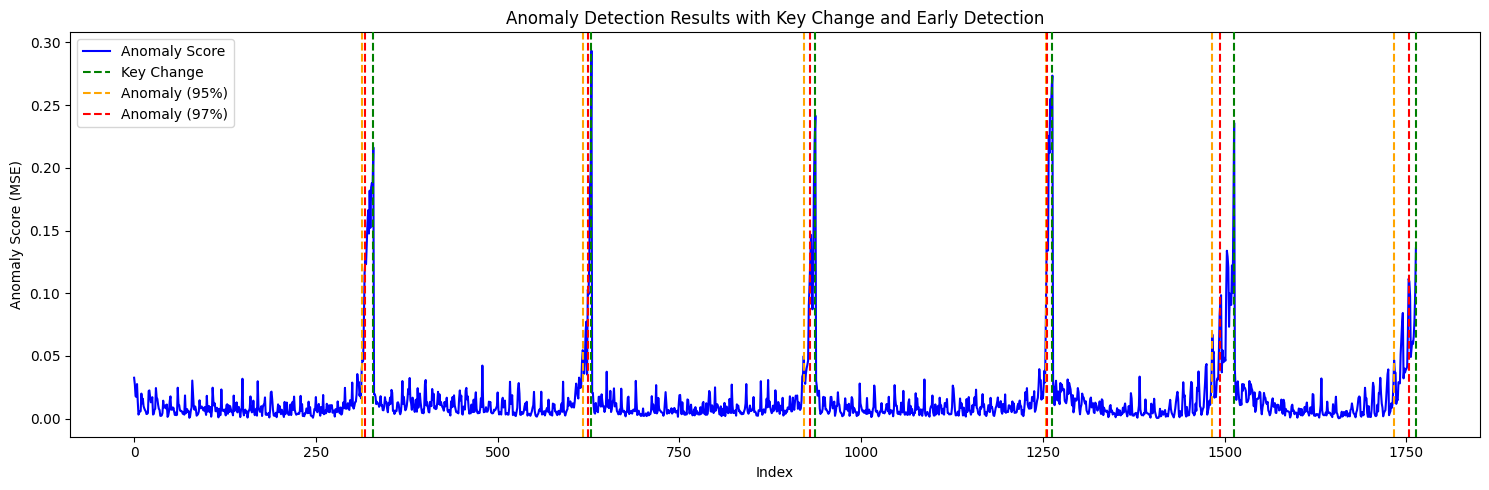

In [28]:
# wandb.init(project="BISTelligen_Project_Analysis", name="model_vqvae_241110")

# Detect key change points and store indices of changes
key_change_indices = m_df.index[m_df['key'].diff() != 0].tolist()

# Adjust to capture the previous index (the one before the change)
key_change_indices = [m_df.index[i - 1] for i in range(1, len(m_df.index)) if m_df['key'].iloc[i] != m_df['key'].iloc[i - 1]]

# Remove index 0 if it's in the list
key_change_indices = [idx for idx in key_change_indices if idx != 0]

# Add the last index to key_change_indices
key_change_indices.append(m_df.index[-1])

# Predict Anomalies on m_df (same as before)
model.eval()
X_test_tensor = torch.tensor(data_without_key.values, dtype=torch.float32)
with torch.no_grad():
    recon_x, z_e = model(X_test_tensor)

# Calculate anomaly scores using reconstruction error (MSE)
anomaly_scores = torch.mean((X_test_tensor - recon_x) ** 2, dim=1).numpy()

# Set a threshold for anomaly detection (e.g., using the 95th percentile)
threshold_95 = np.percentile(anomaly_scores, 95)
anomalies_95 = anomaly_scores >= threshold_95

anomalies_95_indices = []

# Set a threshold for anomaly detection (e.g., using the 99th percentile)
threshold_97 = np.percentile(anomaly_scores, 97)
anomalies_97 = anomaly_scores >= threshold_97

anomalies_97_indices = []

# Visualize Results with Key Change Points and Anomaly Detection
plt.figure(figsize=(15, 5))

# Adjust the starting point of the index to match the length of anomaly_scores
start_index = window_size  # Start after the initial window

# Slice anomaly_scores to match the length of m_df.index[start_index:]
anomaly_scores_sliced = anomaly_scores[:len(m_df.index[0:])]

# Plot the anomaly scores
plt.plot(m_df.index[0:], anomaly_scores_sliced, label='Anomaly Score', color='blue')

for key in m_df['key'].unique():
    key_data = m_df[m_df['key'] == key]

    anomalies_95_key = anomalies_95[key_data.index]
    first_anomaly_95_idx = key_data.index[anomalies_95_key].min() if anomalies_95_key.any() else None
    anomalies_97_key = anomalies_97[key_data.index]
    first_anomaly_97_idx = key_data.index[anomalies_97_key].min() if anomalies_97_key.any() else None

    # Append to the corresponding lists
    if first_anomaly_95_idx is not None:
        anomalies_95_indices.append(first_anomaly_95_idx)
    if first_anomaly_97_idx is not None:
        anomalies_97_indices.append(first_anomaly_97_idx)

# Plot vertical lines for each key
for i, idx in enumerate(key_change_indices):
    plt.axvline(x=m_df.index[idx], color='green', linestyle='--', label='Key Change' if i == 0 else None, zorder=5)

for i, idx in enumerate(anomalies_95_indices):
    plt.axvline(x=idx, color='orange', linestyle='--', label='Anomaly (95%)' if i == 0 else None)

for i, idx in enumerate(anomalies_97_indices):
    plt.axvline(x=idx, color='red', linestyle='--', label='Anomaly (97%)' if i == 0 else None)

key_change_indices.insert(0, 0)
prediction_lines_95 = []
prediction_lines_97 = []

# Calculate the percentage location of each red line within its corresponding green segment
for i in range(1, len(key_change_indices)):
    start_idx = key_change_indices[i - 1] if i == 1 else key_change_indices[i - 1] + 1
    end_idx = key_change_indices[i]

    # Find red lines within this range
    orange_lines_in_range = [idx for idx in anomalies_95_indices if start_idx <= idx <= end_idx]

    # Calculate the percentage for each red line within the range
    if orange_lines_in_range:
        range_length = end_idx - start_idx
        for orange_idx in orange_lines_in_range:
            percentage_location = (orange_idx - start_idx) / range_length * 100
            prediction_lines_95.append(percentage_location)
            print_text_95 = f"Orange line at index {orange_idx} is at {percentage_location:.2f}% of the range from {start_idx} to {end_idx}."
            print(print_text_95)
            # wandb.log({"Log_95%": print_text_95})

print('======================================================')

for i in range(1, len(key_change_indices)):
    start_idx = key_change_indices[i - 1] if i == 1 else key_change_indices[i - 1] + 1
    end_idx = key_change_indices[i]

    # Find red lines within this range
    red_lines_in_range = [idx for idx in anomalies_97_indices if start_idx <= idx <= end_idx]

    # Calculate the percentage for each red line within the range
    if red_lines_in_range:
        range_length = end_idx - start_idx
        for red_idx in red_lines_in_range:
            percentage_location = (red_idx - start_idx) / range_length * 100
            prediction_lines_97.append(percentage_location)
            print_text_97 = f"Red line at index {red_idx} is at {percentage_location:.2f}% of the range from {start_idx} to {end_idx}."
            print(print_text_97)
            # wandb.log({"Log_97%": print_text_97})
print('======================================================')
prediction_mean_95 = np.mean(prediction_lines_95)
prediction_mean_97 = np.mean(prediction_lines_97)
print(f"Prediction Result(95%): {prediction_mean_95:.2f}%")
print(f"Prediction Result(97%): {prediction_mean_97:.2f}%")
# wandb.log({
#     "Prediction Result (95%)": prediction_mean_95,
#     "Prediction Result (97%)": prediction_mean_97
# })

# Plot the results
plt.title('Anomaly Detection Results with Key Change and Early Detection')
plt.xlabel('Index')
plt.ylabel('Anomaly Score (MSE)')
plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig(f"{image_path}/anomaly_detection_plot_vqvae_241110.png")  # Save plot as a file

# Log the plot image to wandb
# wandb.log({"Anomaly Detection Plot": wandb.Image(f"{image_path}/anomaly_detection_plot_vqvae_241110.png")})
plt.show()
# wandb.finish()